In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import regionmask
import geopandas as gp
import pandas as pd

import ipywidgets as widgets
from ipywidgets import *

In [2]:
data = xr.open_dataset("../data/nsidc_iceage.1984_2020.7daily.nc")

In [3]:
iceage = data.age_of_sea_ice[420,:,:]

In [4]:
lat = data['latitude']
lon = data['longitude']

In [5]:
iceage_mask = iceage.where((iceage!=20)&(iceage!=21))

In [ ]:
iceage_mask.

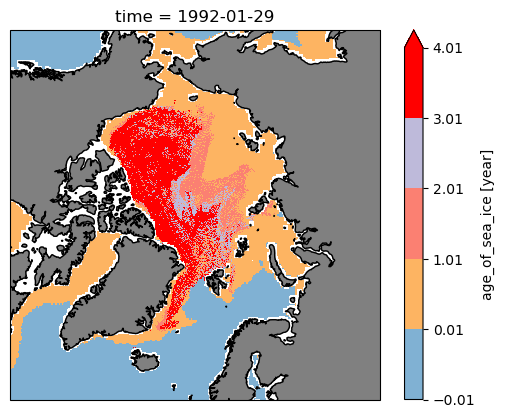

In [45]:
iceage_mask = iceage.where((iceage!=20)&(iceage!=21))

colors = ["white","#80b1d3","#fdb462","#b3de69","#fb8072","#bebada","red"]
boundary = [-0.01,0.01,1.01,2.01,3.01,4.01]
iceage_cm = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(boundaries=boundary, ncolors=iceage_cm.N, extend='both')

proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
ax = plt.axes(projection = proj)
ax.coastlines()
ax.add_feature(cfeature.LAND,color="gray")
ax.set_extent([-180,180,60,90],ccrs.PlateCarree())
iceage_mask.plot.pcolormesh(ax=ax, cmap=iceage_cm, norm=norm)

In [53]:
ArcticSea_shapefile = gp.read_file("../data/ArcticSeaShapefile/iho.shp")
BeringSea_shapefile = gp.read_file("../data/BeringSeaShapefile/iho.shp")
OkhotskSea_shapefile = gp.read_file("../data/OkhotskSeaShapefile/iho.shp")
LabradorSea_shapefile = gp.read_file("../data/LabradorSeaShapefile/iho.shp")

Region_shapefile = ArcticSea_shapefile.append(
                                              [BeringSea_shapefile, OkhotskSea_shapefile, LabradorSea_shapefile],
                                              ignore_index=True)

C:\Users\37\AppData\Local\Temp\ipykernel_356\99579330.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Region_shapefile = ArcticSea_shapefile.append(


In [54]:
drop_names = ['Hudson Strait','White Sea','The Northwestern Passages','Norwegian Sea',
              'Davis Strait','Baffin Bay','Labrador Sea','Bering Sea','Sea of Okhotsk','Hudson Bay']

Region_shapefile.drop(Region_shapefile[Region_shapefile.name.isin(drop_names)].index, inplace=True)
Region_shapefile.set_index('name', drop=True,inplace=True)

In [55]:
def shapefile_concat(shapefile, concat_index, concat_name):
    '''
    Args:
        shapefile: A GeoPandaDataFrame readed by geopandas
        concat_index: The names of regions needed to be concat, such as ['Davis Strait','Baffin Bay','Labrador Sea']
        concat_name: The name of concatted region in new pdDataFrame, such as 'DavBafLab'
    Return:
        A new GeoPandaDataFrame, which include new row named (concat_name), with the old index used to concat have been dropped.
    '''
    shapefile_old = shapefile.copy()
    shapefile_add = pd.Series(dict(
                                    longitude = shapefile.loc[concat_index,'longitude'].mean(),
                                    latitude  = shapefile.loc[concat_index,'latitude'].mean(),
                                    min_x     = shapefile.loc[concat_index,'min_x'].min(),
                                    min_y     = shapefile.loc[concat_index,'min_y'].min(),
                                    max_x     = shapefile.loc[concat_index,'min_x'].max(),
                                    max_y     = shapefile.loc[concat_index,'min_y'].max(),  
                                    area      = shapefile.loc[concat_index,'area'].sum(),
                                    mrgid     = shapefile.loc[concat_index,'mrgid'].sum(),
                                    geometry  = shapefile.loc[concat_index,:].unary_union),
                                name=concat_name)
    shapefile_new = shapefile_old.append(shapefile_add)
    shapefile_new = shapefile_new.drop(concat_index)
    
    return(shapefile_new)

In [56]:
# concat_index = ['Davis Strait','Baffin Bay','Labrador Sea']
# concat_name = 'DavBafLab'
# Region_shapefile = shapefile_concat(Region_shapefile, concat_index=concat_index, concat_name=concat_name)

concat_index = ['Arctic Ocean','Lincoln Sea']
concat_name = 'Arctic'
Region_shapefile = shapefile_concat(Region_shapefile, concat_index=concat_index, concat_name=concat_name)

D:\Application\anaconda\envs\academic\lib\site-packages\pandas\core\dtypes\cast.py:1785: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\37\AppData\Local\Temp\ipykernel_356\1995859978.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shapefile_new = shapefile_old.append(shapefile_add)


In [57]:
region_mask = regionmask.from_geopandas(Region_shapefile.reset_index(drop=False)).mask(lon,lat)
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land.mask(lon,lat)

mask = region_mask.where(land_mask.isnull())

D:\Application\anaconda\envs\academic\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
D:\Application\anaconda\envs\academic\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [77]:
np.unique(region_mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., nan])

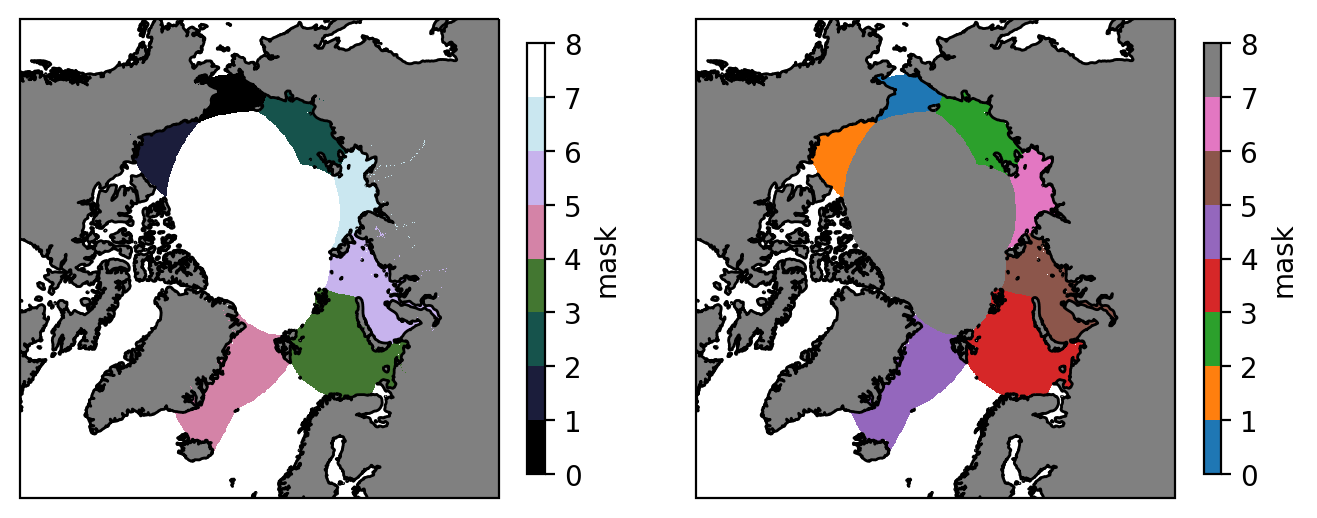

In [178]:
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
fig,ax = plt.subplots(1,2,subplot_kw=dict(projection=proj),dpi=200,figsize=(8,4))

cbar_kwargs = dict(fraction=0.1,aspect=25,shrink=0.7)
plot = region_mask.plot.pcolormesh(ax=ax[0], cmap=plt.cm.get_cmap('cubehelix', 9), 
                                 levels=np.arange(0,9),cbar_kwargs=cbar_kwargs)
ax[0].set_extent([-180,180,60,90],crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].add_feature(cfeature.LAND, color='gray')
cbar = plot.colorbar
# cbar.set_ticks([3.5,5.],labels=['a','b'])
# cbar.ax.minorticks_off()

mask.plot(ax=ax[1], colors=sns.color_palette(), 
                    levels=np.arange(0,9),cbar_kwargs=cbar_kwargs)
ax[1].set_extent([-180,180,60,90],crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].add_feature(cfeature.LAND, color='gray')



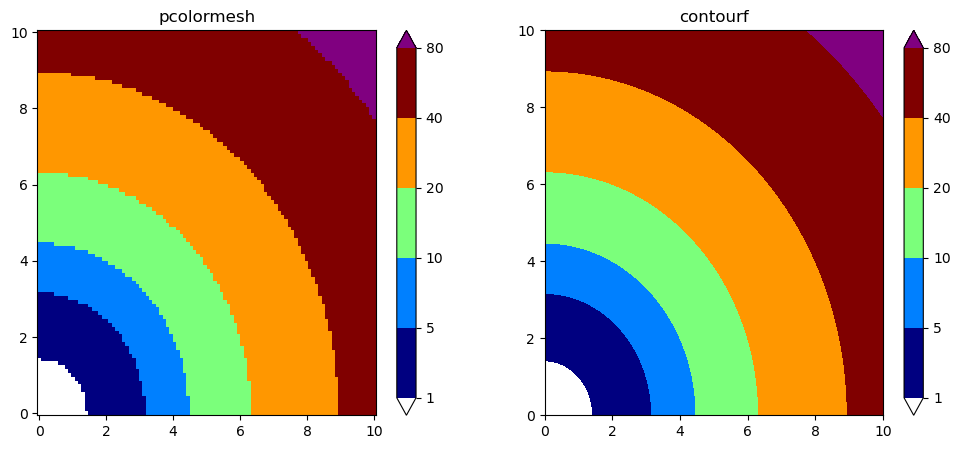

In [187]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# 生成测试数据.
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
Z = X ** 2 + Y ** 2
# 将Z的值缩放到[0, 100]内.
Z = Z / Z.max() * 100

# 设置norm.
bins = [1, 5, 10, 20, 40, 80]
nbin = len(bins) - 1
norm = mcolors.BoundaryNorm(bins, nbin)
# 设置cmap.
cmap = cm.get_cmap('jet', nbin)
cmap.set_under('white')
cmap.set_over('purple')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 使用pcolormesh.
im = axes[0].pcolormesh(X, Y, Z, cmap=cmap, norm=norm, shading='nearest')
cbar = fig.colorbar(im, ax=axes[0], ticks=bins, extend='both')
axes[0].set_title('pcolormesh')


# 使用contourf.
im = axes[1].contourf(
    X, Y, Z, levels=bins, cmap=cmap, norm=norm, extend='both'
)
cbar = fig.colorbar(im, ax=axes[1], ticks=bins)
axes[1].set_title('contourf')

plt.show()


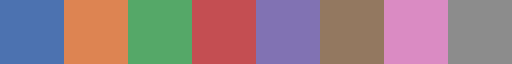

In [172]:
mpl.colors.ListedColormap(sns.color_palette('deep'),name='my_cmap',N=8)

TypeError: 'norm' must be an instance of matplotlib.colors.Normalize, str or None, not a matplotlib.colors.ListedColormap

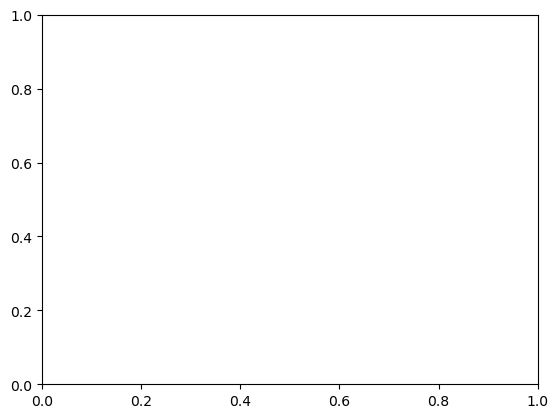

In [175]:
ax = plt.axes()
cm = plt.cm.ScalarMappable(mpl.colors.ListedColormap(sns.color_palette('deep'),name='my_cmap',N=8),)
fig.colorbar(cm,ax)

In [135]:
cbar.set_ticks([1.5,3.])

In [125]:
cbar.ax.yaxis.minor.

In [ ]:
proj = ccrsfrom_geopandasambertAzimuthalEqualArea(central_latitude=90)

ax = plt.axes(projection=proj)
ax.add_geometries(Region_shapefile['geometry'],ccrs.PlateCarree())

<GeoAxesSubplot: >

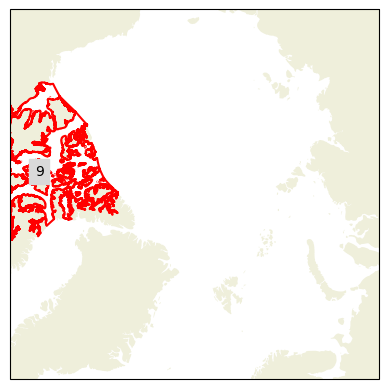

In [80]:

fig = plt.figure()
ax = plt.axes(projection=proj)
ax.set_extent([-180,180,70,80],ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)

Region_mask = regionmask.from_geopandas(Region_shapefile,names='name')
Region_mask[[9]].plot_regions(ax=ax,line_kws=dict(color="red"))

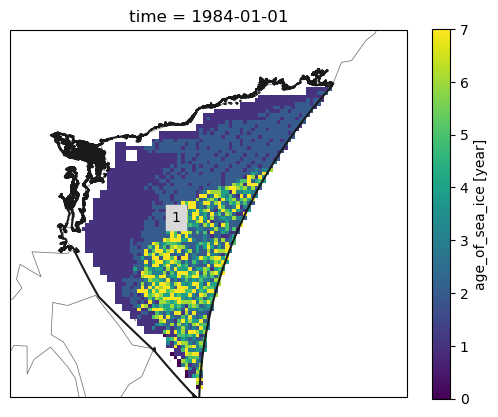

In [56]:
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
ax = plt.axes(projection= proj)
Arctic_region[[1]].plot(ax=ax)

mask = Arctic_region[[1]].mask(lon,lat)
iceage_mask = iceage.where(np.logical_and(mask==1,iceage<=16))

iceage_mask.plot(ax=ax)
ax.set_extent([-160,-120,70,75],crs=ccrs.PlateCarree())
plt.show()

In [51]:
np.logical_and(iceage!=20,iceage!=1)

<xarray.DataArray 'age_of_sea_ice' (y: 722, x: 722)>
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * x        (x) float32 -4.518e+06 -4.506e+06 ... 4.506e+06 4.518e+06
  * y        (y) float32 -4.518e+06 -4.506e+06 ... 4.506e+06 4.518e+06
    time     datetime64[ns] 1984-01-01